In [1]:
import sys
sys.path.append( '../Model/' )
from torch_geometric.datasets.sbm_dataset import StochasticBlockModelDataset
import torch
from torch_geometric.utils import to_networkx
import networkx as nx
from vq_vae import *
import matplotlib.pyplot as plt
from torch_geometric.utils import negative_sampling


/Users/liushuhan/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/data/storage.py:271: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


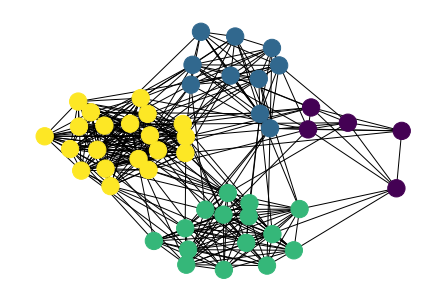

In [2]:
# mat = [[0.9,0.1,0.1,0.1,0.1], [0.1,0.9,0.1,0.1,0.1], [0.1,0.1,0.9,0.1,0.1], [0.1,0.1,0.1,0.9,0.1], [0.1,0.1,0.1,0.1,0.9]]
# size = [10,10,10,10,10]
mat = [[0.9,0.1,0.1,0.1], [0.1,0.9,0.1,0.1], [0.1,0.1,0.9,0.1], [0.1,0.1,0.1,0.9]]
size = [5,10,15,20]
# mat = [[0.8,0.1,0.1], [0.1,0.8,0.1], [0.1,0.1,0.8]]
# size = [500,500,500]
gen = StochasticBlockModelDataset("data", block_sizes=torch.tensor(size), edge_probs=torch.tensor(mat), is_undirected=True)
data = gen.data
G = to_networkx(data, to_undirected=True)
nx.draw(G, node_color=data.y)
# Fix negative edges
# neg_edge_index = negative_sampling(data.edge_index, num_neg_samples=sum(size)*10)
# torch.save(neg_edge_index, "data//edge_neg_small_unbalanced")
neg_edge_index = torch.load("data//edge_neg_small_unbalanced")

In [3]:
def train_plot_model(prior_beta, beta, lr, epochs=1000):
    hidden_dim = 64
    latent_dim = 64
    num_latent = 30
    prior_alpha  = 1
    input_dim = 15
    torch.manual_seed(2000)
    # Initial data
    data.x = torch.randn(sum(size),input_dim)
    # model
    torch.manual_seed(2000)
    model = sb_vq_vae(input_dim, hidden_dim, latent_dim, num_latent, beta, prior_alpha, prior_beta)

    # move to GPU (if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    # inizialize the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr)

    def train(epoch):
        model.train()
        latent_embedding, quantized_latents, codebook, recon_loss, kl_prior1_loss, pi, v, vq_loss = model(x, edge_index, neg_edge_index=neg_edge_index)
        optimizer.zero_grad()
        loss =   recon_loss +   kl_prior1_loss  + vq_loss # +  0.001 * kl_cat_loss  + 0.001 * torch.abs(kl_kumar_loss)
        loss.backward()
        optimizer.step()
        # for name, params in model.named_parameters():
        #     print(name, eval('model.'+name).grad)
        # for name, parma in model.named_parameters():
        #     print(name, eval('model.'+name).grad, parma.shape)
        return float(loss), latent_embedding, quantized_latents, codebook, recon_loss, kl_prior1_loss, pi, v, vq_loss

    loss_min = torch.tensor([100000]) 
    rec = []
    prior_rec = []
    recon_rec = []
    vq_loss_rec = []

    for epoch in range(1, epochs + 1):
        loss, latent_embedding, quantized_latents, codebook, recon_loss, kl_prior1_loss, pi, v, vq_loss = train(epoch)
        rec.append(loss)
        prior_rec.append(float(kl_prior1_loss))
        recon_rec.append(float(recon_loss))
        vq_loss_rec.append(float(vq_loss))
        # for name, param in model.named_parameters():
        #     print(name, eval('model.'+name).grad)
        if loss < loss_min:
            loss_min = loss
            model.eval()
            latent_embedding_min, quantized_latents_min, codebook_min, recon_loss_min, kl_prior1_loss_min, pi_min, v_min, vq_loss_min = model(x, edge_index, neg_edge_index=neg_edge_index)

        if epoch % 100 == 0:
            print('Epoch:{:03d}, loss:{:.4f}'.format(epoch, loss))
            # print(quantized_latents[0,:])
            # for p in model.parameters():
            #     print(p[:,0])
    plt.plot(prior_rec)
    plt.plot(recon_rec)
    plt.plot(vq_loss_rec)
    model.eval()
    _, color = torch.unique(torch.sum(torch.round(quantized_latents_min, decimals=4), dim=1), return_inverse=True)
    return prior_rec, recon_rec, vq_loss_rec, color
    
def purity(color, label):
    pur = torch.zeros(torch.max(color)+1, torch.max(label)+1)
    for i in range(torch.max(color)+1):
        for j in range(torch.max(label)+1):
            pur[i,j] = torch.sum((color==i) & (label==j)) / torch.sum(color==i)
    return pur



In [4]:
lr = 1e-2
epochs = 1000

/Users/liushuhan/opt/anaconda3/lib/python3.9/site-packages/torch/distributions/distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


Epoch:100, loss:3.1698
Epoch:200, loss:2.1552
Epoch:300, loss:1.8971
Epoch:400, loss:1.8708
Epoch:500, loss:1.8684
Epoch:600, loss:1.8671
Epoch:700, loss:1.8677
Epoch:800, loss:1.8662
Epoch:900, loss:1.8666
Epoch:1000, loss:1.8658
tensor([[0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.3333, 0.6667, 0.0000, 0.0000]])
tensor(2)
1.0365017652511597 0.8258799314498901 0.0033934565726667643


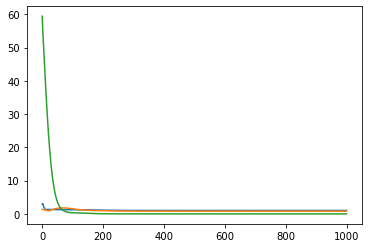

In [5]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=0.5, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[len(prior_rec)-1], recon_rec[len(prior_rec)-1], vq_loss_rec[len(prior_rec)-1])

Epoch:100, loss:2.8791
Epoch:200, loss:1.7302
Epoch:300, loss:1.5040
Epoch:400, loss:1.4774
Epoch:500, loss:1.4758
Epoch:600, loss:1.4753
Epoch:700, loss:1.4750
Epoch:800, loss:1.4766
Epoch:900, loss:1.4746
Epoch:1000, loss:1.4747
tensor([[0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.3333, 0.6667, 0.0000, 0.0000]])
tensor(2)
0.6444215178489685 0.8258476257324219 0.00442296639084816


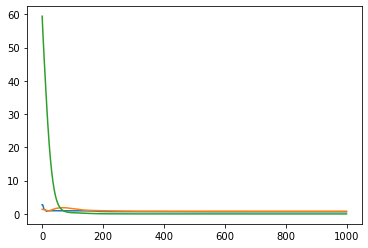

In [6]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=1, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[len(prior_rec)-1], recon_rec[len(prior_rec)-1], vq_loss_rec[len(prior_rec)-1])

Epoch:100, loss:2.7374
Epoch:200, loss:1.6787
Epoch:300, loss:1.4340
Epoch:400, loss:1.4000
Epoch:500, loss:1.3973
Epoch:600, loss:1.3959
Epoch:700, loss:1.3964
Epoch:800, loss:1.3968
Epoch:900, loss:1.3952
Epoch:1000, loss:1.3955
tensor([[0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.3333, 0.6667, 0.0000, 0.0000]])
tensor(2)
0.5657587647438049 0.8258284330368042 0.0038972687907516956


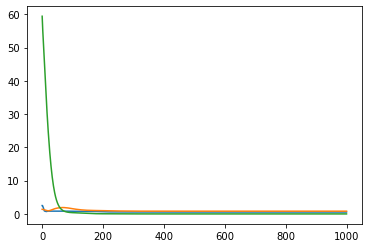

In [7]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=1.5, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:2.6580
Epoch:200, loss:1.6286
Epoch:300, loss:1.4288
Epoch:400, loss:1.4012
Epoch:500, loss:1.3990
Epoch:600, loss:1.3973
Epoch:700, loss:1.3973
Epoch:800, loss:1.3965
Epoch:900, loss:1.3966
Epoch:1000, loss:1.3969
tensor([[0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.3333, 0.6667, 0.0000, 0.0000]])
tensor(3)
0.5695956349372864 0.8241591453552246 0.0031628883443772793


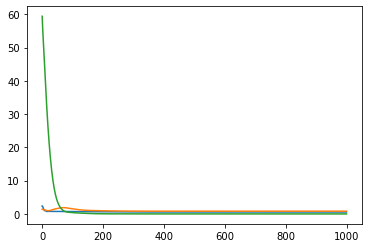

In [8]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=2.0, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:2.7289
Epoch:200, loss:1.6302
Epoch:300, loss:1.4276
Epoch:400, loss:1.4004
Epoch:500, loss:1.3987
Epoch:600, loss:1.3984
Epoch:700, loss:1.4020
Epoch:800, loss:1.3983
Epoch:900, loss:1.3982
Epoch:1000, loss:1.3991
tensor([[0.3750, 0.6250, 0.0000, 0.0000],
        [0.2857, 0.7143, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]])
tensor(4)
0.5828050374984741 0.8123842477798462 0.003938096109777689


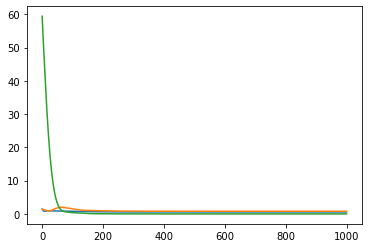

In [9]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=5.0, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:2.5498
Epoch:200, loss:1.6038
Epoch:300, loss:1.4276
Epoch:400, loss:1.4023
Epoch:500, loss:1.4010
Epoch:600, loss:1.3991
Epoch:700, loss:1.3987
Epoch:800, loss:1.3995
Epoch:900, loss:1.4004
Epoch:1000, loss:1.3976
tensor([[0.3636, 0.6364, 0.0000, 0.0000],
        [0.2500, 0.7500, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]])
tensor(7)
0.6027616262435913 0.7886993288993835 0.006134161725640297


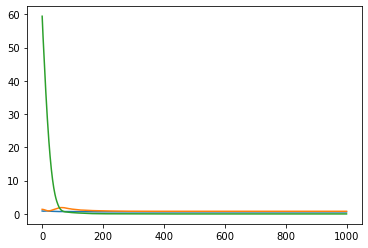

In [10]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=10.0, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:2.8797
Epoch:200, loss:1.7427
Epoch:300, loss:1.5971
Epoch:400, loss:1.5678
Epoch:500, loss:1.5640
Epoch:600, loss:1.5633
Epoch:700, loss:1.5614
Epoch:800, loss:1.5597
Epoch:900, loss:1.5591
Epoch:1000, loss:1.5592
tensor([[0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.2857, 0.7143, 0.0000, 0.0000],
        [0.4286, 0.5714, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]])
tensor(10)
0.7757669687271118 0.7791458964347839 0.00427114637568593


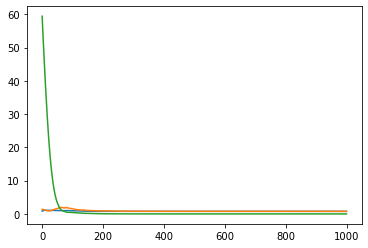

In [11]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=20, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:3.9484
Epoch:200, loss:2.8575
Epoch:300, loss:2.6163
Epoch:400, loss:2.5857
Epoch:500, loss:2.5827
Epoch:600, loss:2.5809
Epoch:700, loss:2.5797
Epoch:800, loss:2.5786
Epoch:900, loss:2.5789
Epoch:1000, loss:2.5763
tensor([[0.2500, 0.7500, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.3750, 0.6250, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]])
tensor(11)
1.8009566068649292 0.7717809677124023 0.0035873865708708763


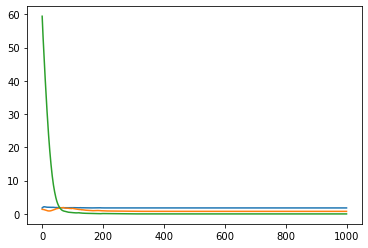

In [12]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=100, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:5.3478
Epoch:200, loss:4.5806
Epoch:300, loss:4.3380
Epoch:400, loss:4.3130
Epoch:500, loss:4.3064
Epoch:600, loss:4.3026
Epoch:700, loss:4.2936
Epoch:800, loss:4.2940
Epoch:900, loss:4.2885
Epoch:1000, loss:4.2892
tensor([[0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.3333, 0.6667, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000]])
tensor(16)
3.5159618854522705 0.7620390057563782 0.011

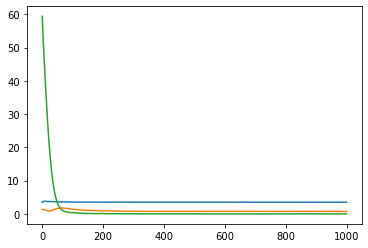

In [13]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=10000, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])